# Assignment 2: Clustering
MBAN 6120 U - DATA SCIENCE II

Neil Haolan Xu & Allen Lin Yang

Oct. 30th, 2024

# I. Data Prepocessing

1. Load the dataset

In [41]:
import pandas as pd

# Read the dataset
url = "https://raw.githubusercontent.com/neilaxu/schulich_data_science/main/DS2/Customer_Data.csv"
df = pd.read_csv(url)


2. Check the basic information of the dataset

In [42]:
print("Shape of data:", df.shape)
print("\nColumns of data:", df.columns.tolist())
print("\nInfo of data:")
df.info()
print("\nHead of data:")
print(df.head())
print("\nTail of data:")
print(df.tail())

Shape of data: (8950, 18)

Columns of data: ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

Info of data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 

3. Check and handling the missing values

In [43]:
# Check for missing values
print("Missing values count:")
print(df.isnull().sum())

# Calculate percentage of missing values
print("\nPercentage of missing values:")
print((df.isnull().sum() / len(df) * 100).round(2))

Missing values count:
CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Percentage of missing values:
CUST_ID                             0.00
BALANCE                             0.00
BALANCE_FREQUENCY                   0.00
PURCHASES                           0.00
ONEOFF_PURCHASES                    0.00
INSTALLME

In [44]:
from sklearn.impute import KNNImputer
import numpy as np

# First handle the single missing value in CREDIT_LIMIT
df = df.dropna(subset=['CREDIT_LIMIT'])

# Prepare data for KNN imputation of MINIMUM_PAYMENTS
columns_for_imputation = ['PAYMENTS', 'BALANCE', 'CREDIT_LIMIT', 'PRC_FULL_PAYMENT', 'MINIMUM_PAYMENTS']
imputer = KNNImputer(n_neighbors=5)
df[columns_for_imputation] = imputer.fit_transform(df[columns_for_imputation])

# Verify missing values are handled
print("\nRemaining missing values:")
print(df.isnull().sum())


Remaining missing values:
CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


Rationale: For the CREDIT_LIMIT column, since there's only one missing value out of about 9000 records (about 0.01%), dropping this single row won't significantly impact our analysis. For MINIMUM_PAYMENTS, which has more missing values, we use KNN imputation because it preserves the relationships between variables by considering similar customers. The selected features for imputation (PAYMENTS, BALANCE, CREDIT_LIMIT, and PRCFULLPAYMENT) are chosen because they're logically related to minimum payments - total payments and balance indicate payment behavior, credit limit affects payment requirements, and percentage of full payment directly relates to minimum payment patterns. This approach maintains the data's integrity better than simple mean or median imputation.

4. Scaling the columns

In [45]:
from sklearn.preprocessing import MinMaxScaler

# Identify columns that need scaling (not in 0-1 range and not CUST_ID)
columns_to_scale = []
for column in df.columns:
   if column != 'CUST_ID':
       if df[column].max() > 1 or df[column].min() < 0:
           columns_to_scale.append(column)

# Apply Min-Max scaling
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Verify the ranges
print("\nRanges after scaling:")
for column in columns_to_scale:
   print(f"{column}: {df[column].min():.2f} to {df[column].max():.2f}")


Ranges after scaling:
BALANCE: 0.00 to 1.00
PURCHASES: 0.00 to 1.00
ONEOFF_PURCHASES: 0.00 to 1.00
INSTALLMENTS_PURCHASES: 0.00 to 1.00
CASH_ADVANCE: 0.00 to 1.00
CASH_ADVANCE_FREQUENCY: 0.00 to 1.00
CASH_ADVANCE_TRX: 0.00 to 1.00
PURCHASES_TRX: 0.00 to 1.00
CREDIT_LIMIT: 0.00 to 1.00
PAYMENTS: 0.00 to 1.00
MINIMUM_PAYMENTS: 0.00 to 1.00
TENURE: 0.00 to 1.00


Rationale: Highly skewed features can negatively impact clustering algorithms because they create distorted distance measurements between data points. By applying log transformation to features with absolute skewness greater than 2 (a common threshold for high skewness), we make their distributions more symmetric and closer to normal distribution. We use log1p (log(1+x)) instead of simple log to handle zero values which are common in credit card data (e.g., zero purchases or cash advances). This transformation helps maintain the relative differences between small values while reducing the impact of extreme values, which is particularly important for financial data where we often see a few very high values that could otherwise dominate the clustering process.

5. Rationale for Topic Segmentation instead of Using All Features:

Using all features simultaneously for clustering would be suboptimal because different features serve distinct business purposes and might create noise when analyzed together. Mixing all features could obscure important patterns specific to each business objective - for instance, a customer might show risky payment behavior but maintain high purchase volumes, or demonstrate responsible credit use despite lower spending. 

By segmenting our analysis into three focused topics (Risk Assessment, Spending Patterns, and Credit Limit Optimization), we can derive more actionable insights for each specific business need. This segmentation also aligns with how different business units typically operate: risk management teams focus on default prevention, marketing teams on spending patterns, and portfolio management teams on credit limit strategies. The overlapping features across topics (such as BALANCE and PAYMENTS) serve different analytical purposes in each context - they indicate risk levels in the first topic, customer engagement in the second, and growth opportunity in the third. 

Additionally, this segmented approach allows for more targeted interventions: high-risk customers might need payment reminders, distinct spending patterns might suggest specific product offerings, and optimal credit limit management might require different strategies for different customer profiles. Therefore, while our dataset contains various features, organizing them into these three business-aligned topics enables more focused, actionable, and operationally relevant analysis.

a. High-Risk Customer Segments

Selected Features:
- PAYMENTS
- MINIMUM_PAYMENTS
- PRCFULLPAYMENT
- BALANCE
- BALANCEFREQUENCY
- CASHADVANCE
- CASHADVANCEFREQUENCY
- CASHADVANCETRX

Rationale:
High-Risk Customer Segments is a crucial business objective as identifying and managing risky customers is fundamental to credit card business sustainability. Credit risk directly impacts profitability through potential defaults and determines the need for loan loss provisions. The selection of features for this segment focuses on three key risk indicators: payment behavior, balance management, and cash advance usage. Payment-related features (PAYMENTS, MINIMUM_PAYMENTS, PRCFULLPAYMENT) are selected because they reveal both ability and willingness to repay - customers who consistently make only minimum payments or irregular payments often signal financial stress. Balance-related features (BALANCE, BALANCEFREQUENCY) are included as they show debt accumulation patterns and account activity levels - high balances with low payment rates are classic risk indicators. Cash advance features (CASHADVANCE, CASHADVANCEFREQUENCY, CASHADVANCETRX) are particularly important as cash advances often indicate liquidity problems - customers heavily relying on cash advances typically have higher default rates. Together, these features enable a comprehensive risk assessment framework that can help in early identification of potential defaults and guide risk mitigation strategies.

b. Customer Spending Patterns

Selected Features:
- PURCHASES
- ONEOFFPURCHASES
- INSTALLMENTSPURCHASES
- PURCHASESFREQUENCY
- ONEOFFPURCHASESFREQUENCY
- PURCHASES_INSTALLMENTS_FREQUENCY
- PURCHASESTRX

Rationale:
Understanding Customer Spending Patterns is essential for developing targeted marketing strategies, improving customer engagement, and maximizing revenue generation. This objective goes beyond simple transaction monitoring to understand the underlying purchasing behavior and preferences of different customer segments. The feature selection incorporates both transaction values and behavioral indicators to create a complete picture of spending habits. The monetary features (PURCHASES, ONEOFFPURCHASES, INSTALLMENTSPURCHASES) quantify spending levels and show customers' preferred payment methods - some might prefer spreading costs through installments while others opt for immediate full payments. The frequency metrics (PURCHASESFREQUENCY, ONEOFFPURCHASESFREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY) reveal usage patterns and card preference - higher frequencies typically indicate the card being the customer's primary payment method. PURCHASESTRX provides insight into transaction volumes, helping distinguish between high-value occasional users and frequent small-transaction users. This comprehensive view of spending patterns enables better product development, more effective cross-selling opportunities, and personalized marketing campaigns tailored to specific customer segments.

c. Credit Limit Optimization

Selected Features:
- CREDIT_LIMIT
- TENURE
- BALANCE
- PURCHASES
- PAYMENTS
- PRCFULLPAYMENT
- PURCHASESTRX

Rationale:
Credit Limit Optimization is a strategic objective that balances growth opportunities with risk management, directly impacting both customer satisfaction and portfolio profitability. The feature selection for this objective combines historical performance, customer relationship depth, and usage patterns to make informed credit limit decisions. CREDIT_LIMIT and TENURE form the foundation of the analysis - tenure indicates relationship stability and historical performance, while current credit limit serves as a baseline for adjustment. Usage metrics (BALANCE, PURCHASES, PURCHASESTRX) are crucial for understanding how effectively customers utilize their existing limits - consistent high utilization might indicate need for an increase, while low utilization might suggest over-allocation of credit. Payment behavior features (PAYMENTS, PRCFULLPAYMENT) are essential risk indicators - customers who consistently make full payments and manage their credit responsibly are better candidates for limit increases. These features together enable a balanced approach to credit limit optimization, identifying opportunities for limit increases among reliable customers while maintaining appropriate limits for others. This scientific approach to credit limit management helps maximize customer lifetime value while maintaining portfolio quality.

6. Log Transformation

In [46]:
# Calculate skewness for numerical columns (excluding CUST_ID and frequency columns which are already 0-1)
potential_skewed = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 
                  'CASH_ADVANCE', 'PURCHASES_TRX', 'CASH_ADVANCE_TRX', 'CREDIT_LIMIT',
                  'PAYMENTS', 'MINIMUM_PAYMENTS', 'TENURE']

print("Skewness before transformation:")
for column in potential_skewed:
   skew = df[column].skew()
   print(f"{column}: {skew:.2f}")

# Apply log transformation to highly skewed features (|skew| > 2)
# Adding small constant (1) to handle zeros
for column in potential_skewed:
   if abs(df[column].skew()) > 2:
       df[f"{column}_LOG"] = np.log1p(df[column])  # log1p = log(1+x)

print("\nSkewness after transformation (for transformed features):")
for column in df.columns:
   if '_LOG' in column:
       print(f"{column}: {df[column].skew():.2f}")

Skewness before transformation:
BALANCE: 2.39
PURCHASES: 8.14
ONEOFF_PURCHASES: 10.04
INSTALLMENTS_PURCHASES: 7.30
CASH_ADVANCE: 5.17
PURCHASES_TRX: 4.63
CASH_ADVANCE_TRX: 5.72
CREDIT_LIMIT: 1.52
PAYMENTS: 5.91
MINIMUM_PAYMENTS: 13.03
TENURE: -2.94

Skewness after transformation (for transformed features):
BALANCE_LOG: 1.96
PURCHASES_LOG: 6.19
ONEOFF_PURCHASES_LOG: 7.56
INSTALLMENTS_PURCHASES_LOG: 5.61
CASH_ADVANCE_LOG: 4.06
PURCHASES_TRX_LOG: 3.63
CASH_ADVANCE_TRX_LOG: 4.23
PAYMENTS_LOG: 4.70
MINIMUM_PAYMENTS_LOG: 10.21
TENURE_LOG: -3.20


Rationale: Highly skewed features can negatively impact clustering algorithms because they create distorted distance measurements between data points. By applying log transformation to features with absolute skewness greater than 2 (a common threshold for high skewness), we make their distributions more symmetric and closer to normal distribution. We use log1p (log(1+x)) instead of simple log to handle zero values which are common in credit card data (e.g., zero purchases or cash advances). This transformation helps maintain the relative differences between small values while reducing the impact of extreme values, which is particularly important for financial data where we often see a few very high values that could otherwise dominate the clustering process.


# II. Dimensional Reduction and Exploratory Data Analysis (EDA)

1. EDA for High-Risk Customer Segments

Cumulative explained variance ratio:
Number of components: 1, Explained variance: 0.518
Number of components: 2, Explained variance: 0.837
Number of components: 3, Explained variance: 0.947
Number of components: 4, Explained variance: 0.979
Number of components: 5, Explained variance: 0.990
Number of components: 6, Explained variance: 0.994
Number of components: 7, Explained variance: 0.997
Number of components: 8, Explained variance: 1.000


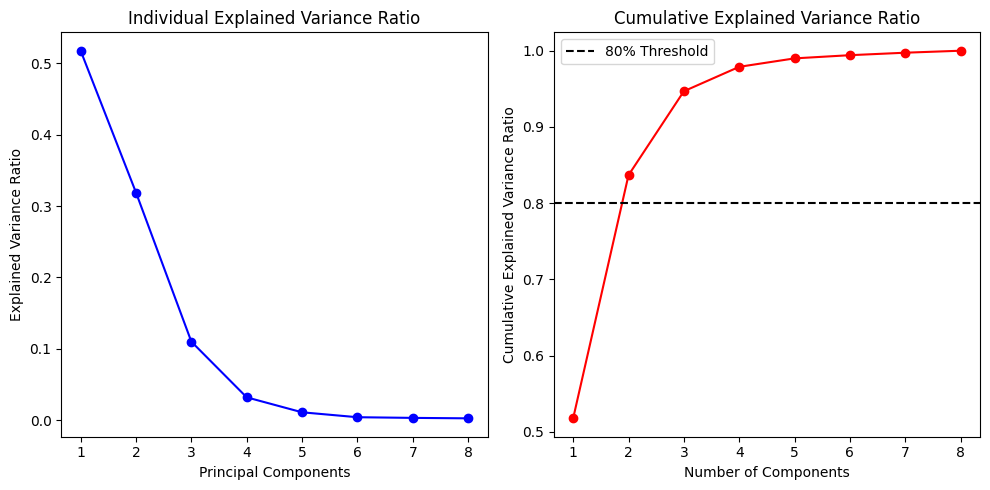

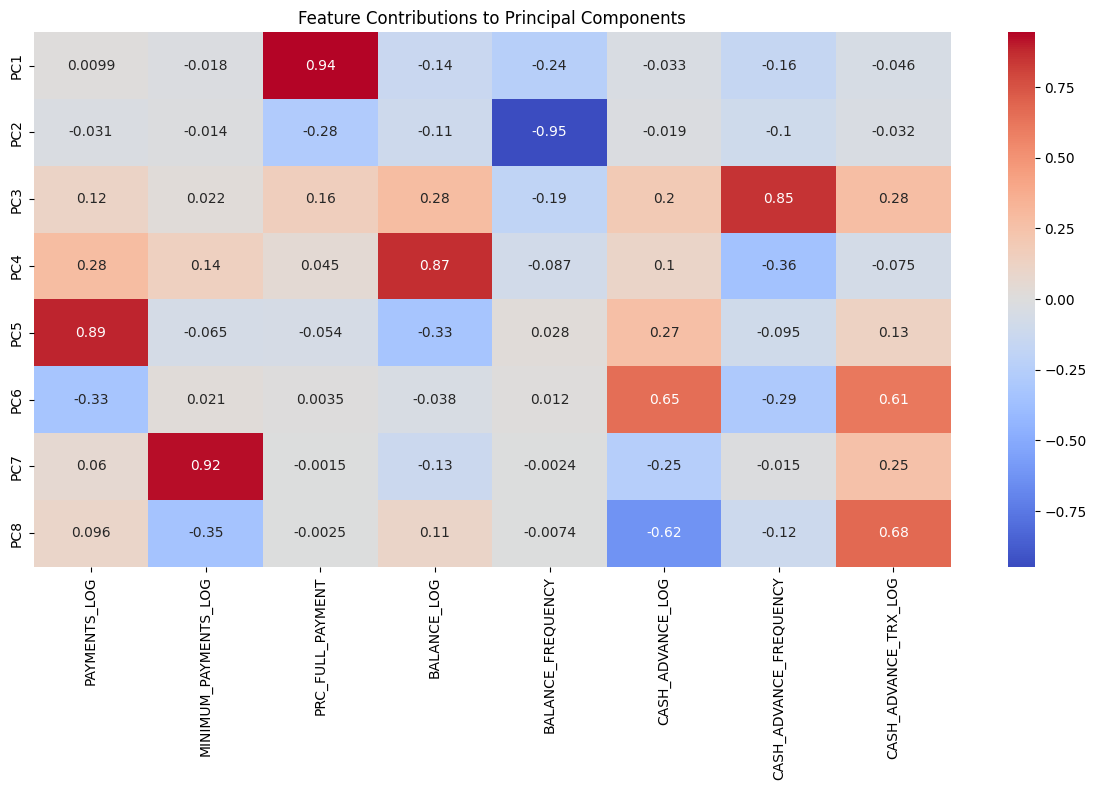


Number of components needed for 80% variance: 2


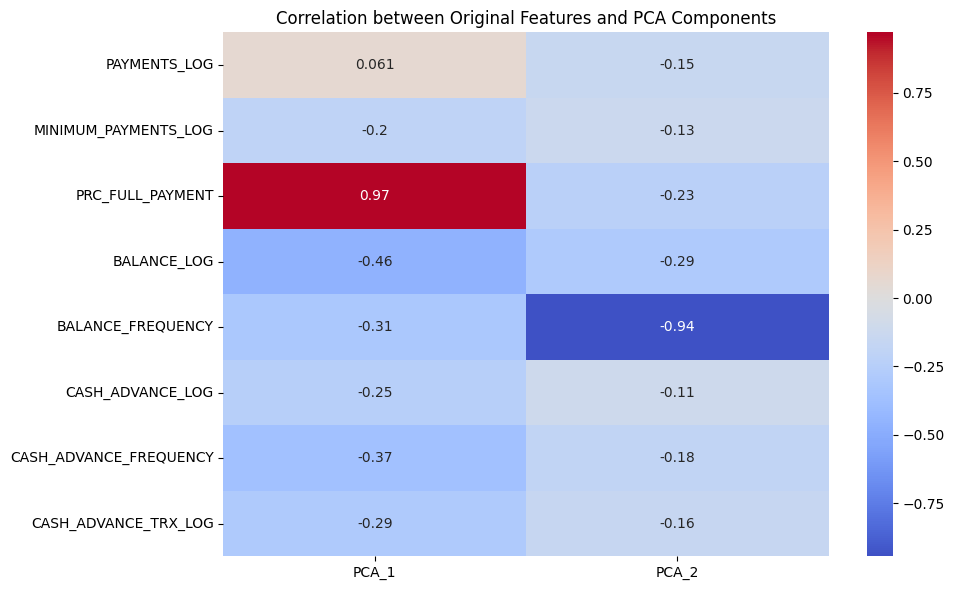


Summary statistics of selected PCA components:
              PCA_1         PCA_2
count  8.949000e+03  8.949000e+03
mean   2.064377e-17  7.225320e-17
std    3.008869e-01  2.361743e-01
min   -3.703477e-01 -3.841536e-01
25%   -1.781732e-01 -1.043550e-01
50%   -1.505008e-01 -7.076876e-02
75%    5.090429e-02  9.674020e-04
max    1.017048e+00  8.933815e-01


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# For High-Risk Customer Segments, prepare data for PCA
# Select relevant features (using log-transformed where available)
risk_features = ['PAYMENTS_LOG', 'MINIMUM_PAYMENTS_LOG', 'PRC_FULL_PAYMENT', 
               'BALANCE_LOG', 'BALANCE_FREQUENCY', 'CASH_ADVANCE_LOG',
               'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX_LOG']

# Prepare data for PCA
X = df[risk_features]

# Apply PCA
from sklearn.decomposition import PCA
pca = PCA()
pca_result = pca.fit_transform(X)

# Calculate explained variance ratio
print("Cumulative explained variance ratio:")
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
for i, ratio in enumerate(cumulative_variance_ratio, 1):
   print(f"Number of components: {i}, Explained variance: {ratio:.3f}")

# Visualize explained variance ratio
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
        pca.explained_variance_ratio_, 'bo-')
plt.title('Individual Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(122)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
        cumulative_variance_ratio, 'ro-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.8, color='k', linestyle='--', label='80% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Feature contribution to principal components
component_df = pd.DataFrame(
   pca.components_,
   columns=risk_features,
   index=[f'PC{i+1}' for i in range(len(pca.components_))]
)

plt.figure(figsize=(12, 8))
sns.heatmap(component_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Contributions to Principal Components')
plt.tight_layout()
plt.show()

# Select number of components that explain 80% variance
n_components = np.where(cumulative_variance_ratio >= 0.8)[0][0] + 1
print(f"\nNumber of components needed for 80% variance: {n_components}")

# Add selected PCA components to dataframe
pca_columns = [f'PCA_{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(pca_result[:, :n_components], columns=pca_columns)

# Show correlation between original features and selected PCA components
correlation_matrix = pd.DataFrame(
   np.corrcoef(X.T, df_pca.T)[:len(risk_features), -n_components:],
   index=risk_features,
   columns=pca_columns
)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Original Features and PCA Components')
plt.tight_layout()
plt.show()

# Print summary of selected PCA components
print("\nSummary statistics of selected PCA components:")
print(df_pca.describe())

# Store PCA components for future clustering
df_pca_final = df_pca.copy()

Analysis of PCA Results for High-Risk Customer Segments:

1. Variance Explained and Component Selection
The PCA analysis reveals that two components can capture 83.7% of the total variance in our data, with the first component explaining 51.8% and the second component adding 31.9%. The sharp decrease in individual explained variance after these two components (shown in the elbow plot) suggests that two components are sufficient for our analysis. This reduction from 8 original features to 2 components significantly simplifies our model while retaining the most important patterns in the data.

2. Feature Contributions and Component Interpretation
PCA_1 is strongly dominated by PRC_FULL_PAYMENT (0.94), suggesting this component primarily represents payment behavior. The negative correlations with balance and cash advance features indicate that higher values of PCA_1 correspond to customers who make full payments and maintain lower balances.
PCA_2 is primarily characterized by a strong negative correlation with BALANCE_FREQUENCY (-0.95), representing the regularity of account usage. This component helps differentiate between customers with consistent versus sporadic account activity.

3. Component Relationships with Original Features
The correlation heatmap between original features and PCA components shows PCA_1 has a strong positive correlation with PRC_FULL_PAYMENT (0.97) and negative correlations with balance and cash advance metrics. PCA_2 shows strong negative correlation with BALANCE_FREQUENCY (-0.94). These relationships confirm that our two components effectively capture the key risk dimensions: payment behavior and account usage patterns.

Recommendation for Clustering:
We should use PCA_1 and PCA_2 as our features for clustering because:
1. They capture 83.7% of the variance while simplifying our feature space
2. They provide clear, interpretable dimensions related to payment behavior and account usage
3. They have removed multicollinearity and reduced noise in the original features
4. The standardized nature of PCA components will help prevent any single dimension from dominating the clustering process

2. EDA for Customer Spending Patterns

Cumulative explained variance ratio:
Number of components: 1, Explained variance: 0.754
Number of components: 2, Explained variance: 0.968
Number of components: 3, Explained variance: 0.991
Number of components: 4, Explained variance: 0.997
Number of components: 5, Explained variance: 0.999
Number of components: 6, Explained variance: 1.000
Number of components: 7, Explained variance: 1.000


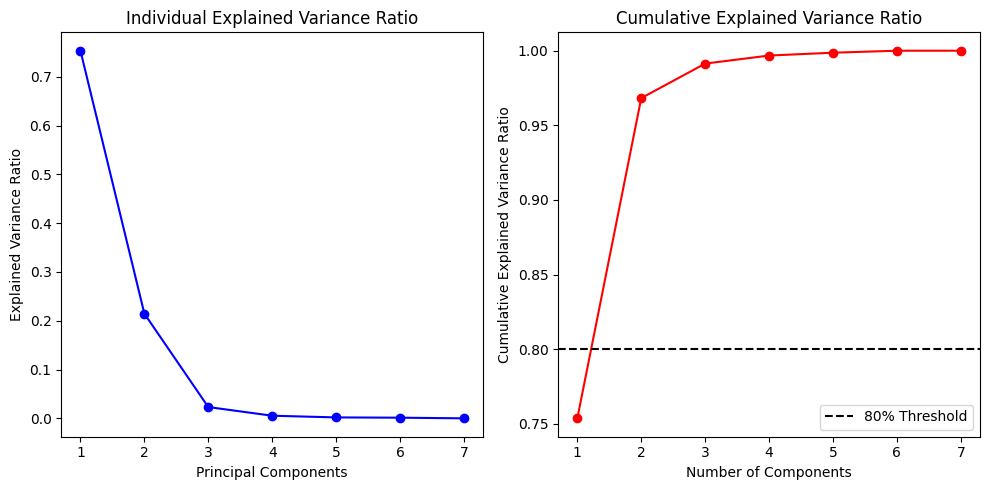

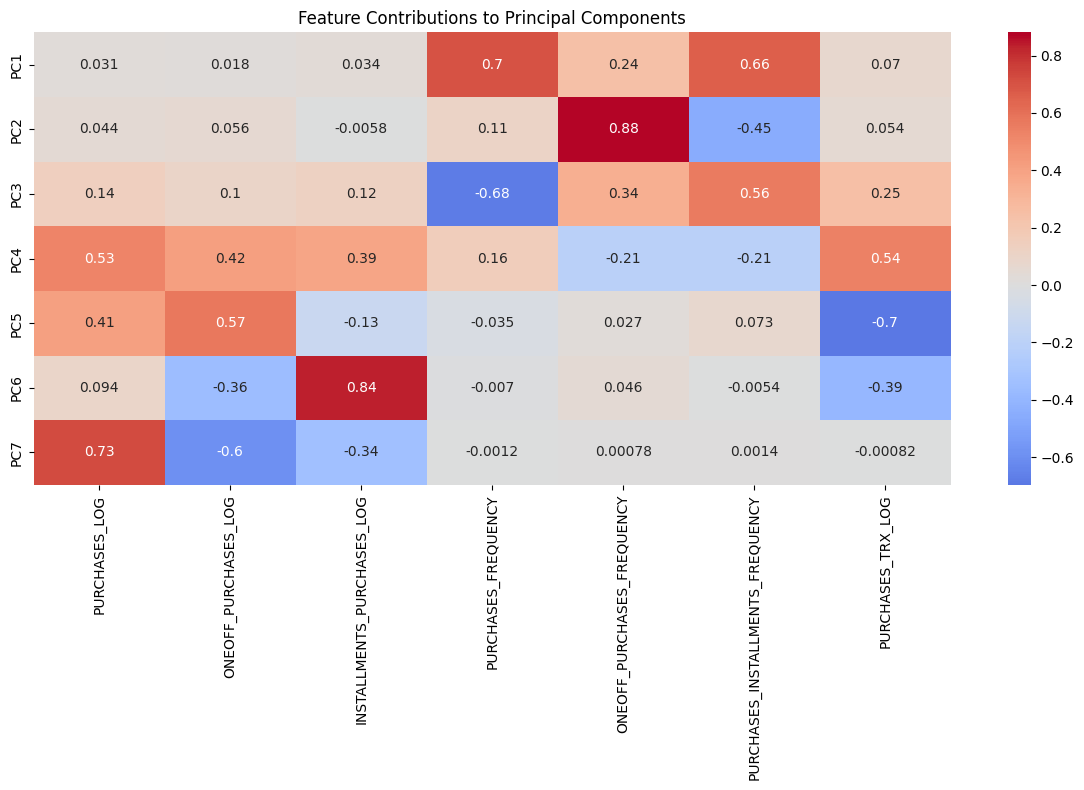


Number of components needed for 80% variance: 2


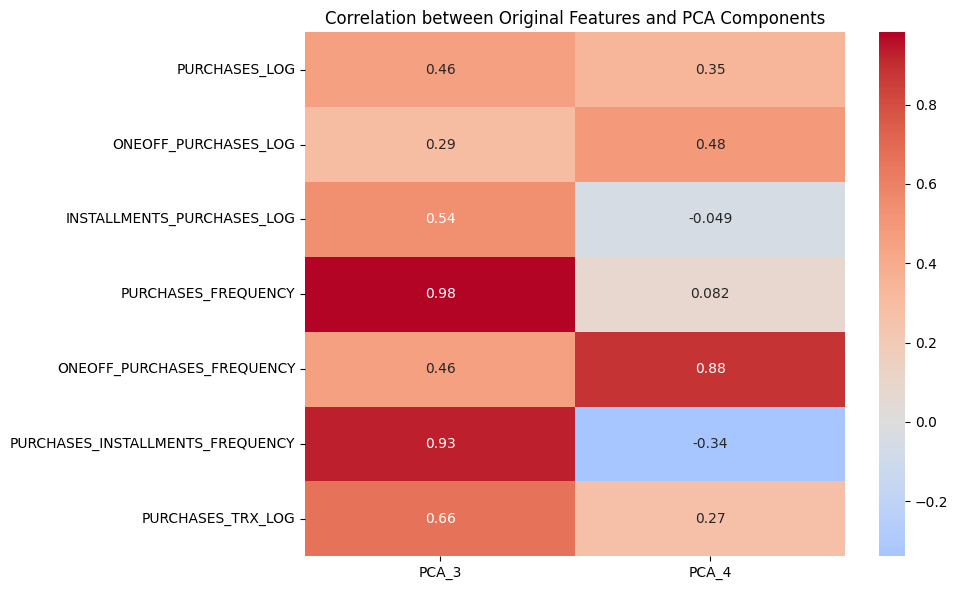


Summary statistics of selected PCA components:
              PCA_3         PCA_4
count  8.949000e+03  8.949000e+03
mean   8.059011e-17  2.381974e-17
std    5.595310e-01  2.985941e-01
min   -6.398974e-01 -4.166021e-01
25%   -5.606127e-01 -1.844742e-01
50%   -7.411092e-02 -7.165404e-02
75%    5.796106e-01  9.623651e-02
max    1.062442e+00  9.696250e-01


In [48]:
# For Customer Spending Patterns, prepare data for PCA
# Select relevant features (using log-transformed where available)
spending_features = ['PURCHASES_LOG', 'ONEOFF_PURCHASES_LOG', 'INSTALLMENTS_PURCHASES_LOG',
                   'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
                   'PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_TRX_LOG']

# Prepare data for PCA
X_spending = df[spending_features]

# Apply PCA
pca_spending = PCA()
pca_spending_result = pca_spending.fit_transform(X_spending)

# Calculate explained variance ratio
print("Cumulative explained variance ratio:")
cumulative_variance_ratio = np.cumsum(pca_spending.explained_variance_ratio_)
for i, ratio in enumerate(cumulative_variance_ratio, 1):
   print(f"Number of components: {i}, Explained variance: {ratio:.3f}")

# Visualize explained variance ratio
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(range(1, len(pca_spending.explained_variance_ratio_) + 1), 
        pca_spending.explained_variance_ratio_, 'bo-')
plt.title('Individual Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(122)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
        cumulative_variance_ratio, 'ro-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.8, color='k', linestyle='--', label='80% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Feature contribution to principal components
component_df = pd.DataFrame(
   pca_spending.components_,
   columns=spending_features,
   index=[f'PC{i+1}' for i in range(len(pca_spending.components_))]
)

plt.figure(figsize=(12, 8))
sns.heatmap(component_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Contributions to Principal Components')
plt.tight_layout()
plt.show()

# Select number of components that explain 80% variance
n_components = np.where(cumulative_variance_ratio >= 0.8)[0][0] + 1
print(f"\nNumber of components needed for 80% variance: {n_components}")

# Add selected PCA components to dataframe
pca_columns = [f'PCA_{i+3}' for i in range(n_components)]  # Starting from PCA_3 since PCA_1 and PCA_2 are used
df_pca_spending = pd.DataFrame(pca_spending_result[:, :n_components], columns=pca_columns)

# Show correlation between original features and selected PCA components
correlation_matrix = pd.DataFrame(
   np.corrcoef(X_spending.T, df_pca_spending.T)[:len(spending_features), -n_components:],
   index=spending_features,
   columns=pca_columns
)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Original Features and PCA Components')
plt.tight_layout()
plt.show()

# Print summary of selected PCA components
print("\nSummary statistics of selected PCA components:")
print(df_pca_spending.describe())

# Store PCA components for future clustering
df_pca_final = pd.concat([df_pca_final, df_pca_spending], axis=1)

Analysis of PCA Results for Customer Spending Patterns:

1. Variance Explained and Component Selection
The PCA analysis for spending patterns shows even stronger dimensionality reduction potential than the risk analysis, with just two components explaining 96.8% of the total variance (75.4% by the first component and 21.4% by the second). The extremely steep drop in the individual explained variance ratio after the second component, as shown in the elbow plot, provides strong justification for using only two components. This is a highly efficient reduction from 7 original features to 2 components while retaining nearly all the information.

2. Feature Contributions and Component Interpretation
PCA_3 (the first component of this set) is strongly characterized by purchase frequency metrics, with high loadings for PURCHASES_FREQUENCY (0.70) and PURCHASES_INSTALLMENTS_FREQUENCY (0.66). This component appears to capture the overall engagement level of customers with their credit cards.
PCA_4 (the second component) is dominated by ONEOFF_PURCHASES_FREQUENCY (0.88), with a negative correlation to PURCHASES_INSTALLMENTS_FREQUENCY (-0.45). This component seems to differentiate between customers who prefer one-off purchases versus those who favor installment payments.

3. Component Relationships with Original Features
The correlation heatmap reveals that PCA_3 has very strong correlations with PURCHASES_FREQUENCY (0.98) and PURCHASES_INSTALLMENTS_FREQUENCY (0.93), while PCA_4 correlates strongly with ONEOFF_PURCHASES_FREQUENCY (0.88). This clear separation in correlations confirms that these components effectively capture two distinct aspects of spending behavior: overall purchase activity and purchase type preference.

Recommendation for Clustering:
We should use PCA_3 and PCA_4 as our features for clustering because:
1. They capture an impressive 96.8% of the variance in spending patterns
2. They clearly separate two key aspects of customer behavior: purchase frequency and purchase type preference
3. The components have clear, interpretable meanings that will make cluster analysis more meaningful
4. The orthogonal nature of the components ensures we're capturing truly distinct aspects of spending behavior

3. EDA for Credit Limit Optimization

Cumulative explained variance ratio:
Number of components: 1, Explained variance: 0.524
Number of components: 2, Explained variance: 0.828
Number of components: 3, Explained variance: 0.941
Number of components: 4, Explained variance: 0.965
Number of components: 5, Explained variance: 0.988
Number of components: 6, Explained variance: 0.998
Number of components: 7, Explained variance: 1.000


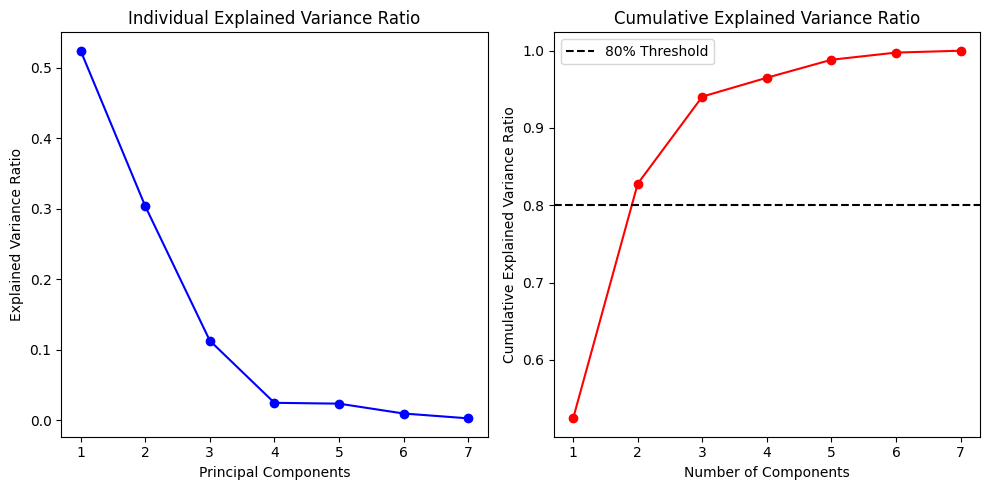

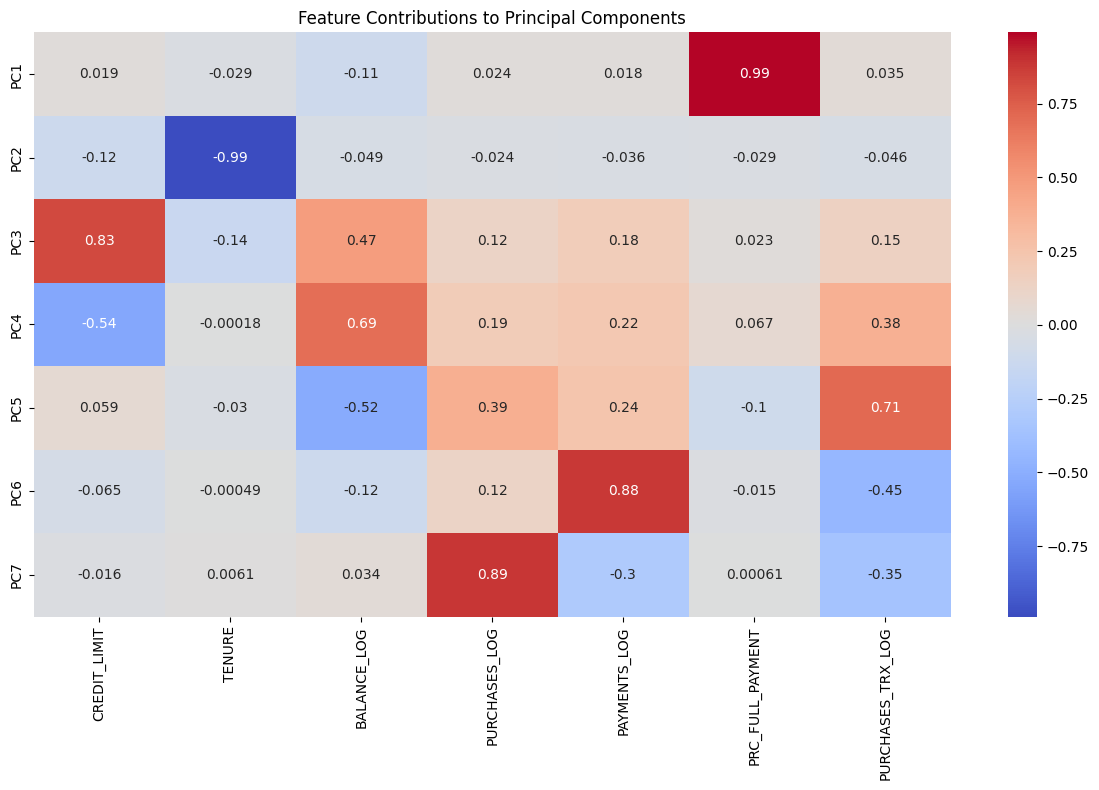


Number of components needed for 80% variance: 2


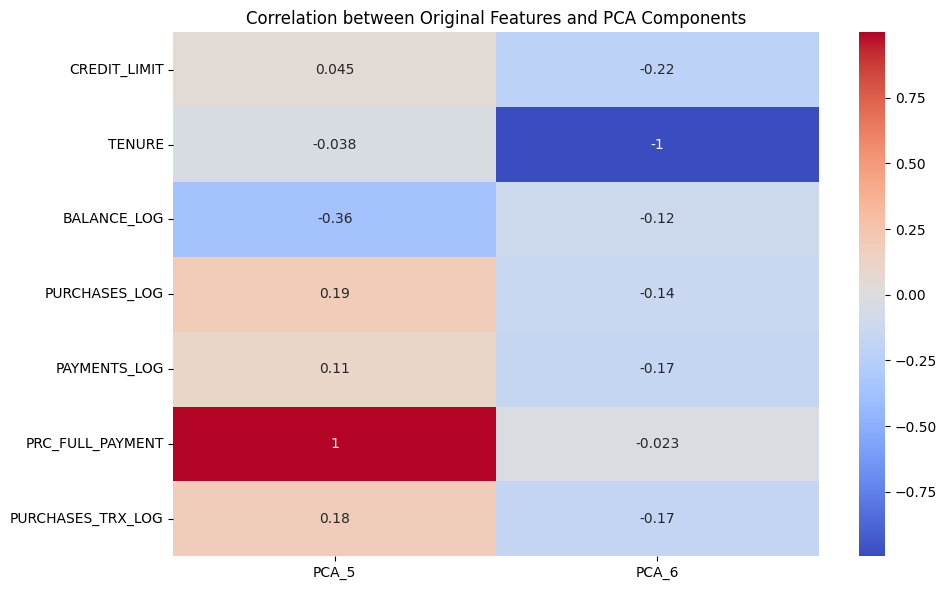


Summary statistics of selected PCA components:
              PCA_5         PCA_6
count  8.949000e+03  8.949000e+03
mean   7.145921e-18  5.716737e-17
std    2.947314e-01  2.243015e-01
min   -2.070116e-01 -2.314048e-01
25%   -1.573867e-01 -8.889658e-02
50%   -1.493435e-01 -6.980598e-02
75%   -7.778079e-03 -5.920840e-02
max    8.840715e-01  9.372265e-01


In [49]:
# For Credit Limit Optimization, prepare data for PCA
# Select relevant features (using log-transformed where available)
credit_features = ['CREDIT_LIMIT', 'TENURE', 'BALANCE_LOG', 
                  'PURCHASES_LOG', 'PAYMENTS_LOG', 'PRC_FULL_PAYMENT',
                  'PURCHASES_TRX_LOG']

# Prepare data for PCA
X_credit = df[credit_features]

# Apply PCA
pca_credit = PCA()
pca_credit_result = pca_credit.fit_transform(X_credit)

# Calculate explained variance ratio
print("Cumulative explained variance ratio:")
cumulative_variance_ratio = np.cumsum(pca_credit.explained_variance_ratio_)
for i, ratio in enumerate(cumulative_variance_ratio, 1):
   print(f"Number of components: {i}, Explained variance: {ratio:.3f}")

# Visualize explained variance ratio
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(range(1, len(pca_credit.explained_variance_ratio_) + 1), 
        pca_credit.explained_variance_ratio_, 'bo-')
plt.title('Individual Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')

plt.subplot(122)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), 
        cumulative_variance_ratio, 'ro-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.8, color='k', linestyle='--', label='80% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Feature contribution to principal components
component_df = pd.DataFrame(
   pca_credit.components_,
   columns=credit_features,
   index=[f'PC{i+1}' for i in range(len(pca_credit.components_))]
)

plt.figure(figsize=(12, 8))
sns.heatmap(component_df, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Contributions to Principal Components')
plt.tight_layout()
plt.show()

# Select number of components that explain 80% variance
n_components = np.where(cumulative_variance_ratio >= 0.8)[0][0] + 1
print(f"\nNumber of components needed for 80% variance: {n_components}")

# Add selected PCA components to dataframe
pca_columns = [f'PCA_{i+5}' for i in range(n_components)]  # Starting from PCA_5 since PCA_1 to PCA_4 are used
df_pca_credit = pd.DataFrame(pca_credit_result[:, :n_components], columns=pca_columns)

# Show correlation between original features and selected PCA components
correlation_matrix = pd.DataFrame(
   np.corrcoef(X_credit.T, df_pca_credit.T)[:len(credit_features), -n_components:],
   index=credit_features,
   columns=pca_columns
)

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Original Features and PCA Components')
plt.tight_layout()
plt.show()

# Print summary of selected PCA components
print("\nSummary statistics of selected PCA components:")
print(df_pca_credit.describe())

# Store PCA components for future clustering
df_pca_final = pd.concat([df_pca_final, df_pca_credit], axis=1)

Analysis of PCA Results for Credit Limit Optimization:

1. Variance Explained and Component Selection
The PCA analysis for credit limit optimization reveals that two components explain 82.8% of the total variance, with the first component accounting for 52.4% and the second adding 30.4%. The elbow plot shows a clear break after the second component, with subsequent components adding minimal explanatory power. This reduction from 7 original features to 2 components while retaining over 80% of the information suggests an efficient dimensionality reduction.

2. Feature Contributions and Component Interpretation
PCA_5 (the first component) is dominated by PRC_FULL_PAYMENT (0.99), indicating it primarily represents payment reliability and financial discipline. The negative correlation with BALANCE_LOG (-0.11) further supports this interpretation as customers who make full payments tend to maintain lower balances.
PCA_6 (the second component) shows a strong negative correlation with TENURE (-0.99), suggesting it captures customer longevity and experience with the credit card. This component helps differentiate between new and established customers, which is crucial for credit limit decisions.

3. Component Relationships with Original Features
The correlation heatmap confirms that PCA_5 has a perfect correlation with PRC_FULL_PAYMENT (1.0), while PCA_6 has a perfect negative correlation with TENURE (-1.0). Other features show relatively weak correlations with these components, indicating that payment behavior and customer tenure are the most distinctive factors in credit limit optimization. This clear separation suggests these components effectively capture the two most important aspects for credit limit decisions: payment reliability and customer history.

Recommendation for Clustering:
We should use PCA_5 and PCA_6 as our features for clustering because:
1. They capture 82.8% of the variance while simplifying the feature space
2. They represent distinct and interpretable aspects of credit worthiness (payment behavior and tenure)
3. The clear alignment with important business factors (payment reliability and customer experience) will make the resulting clusters more actionable for credit limit decisions
4. The orthogonal nature of the components ensures we're capturing independent aspects of customer creditworthiness

4. Further Exam the Features Used in PCAs (Loadings)

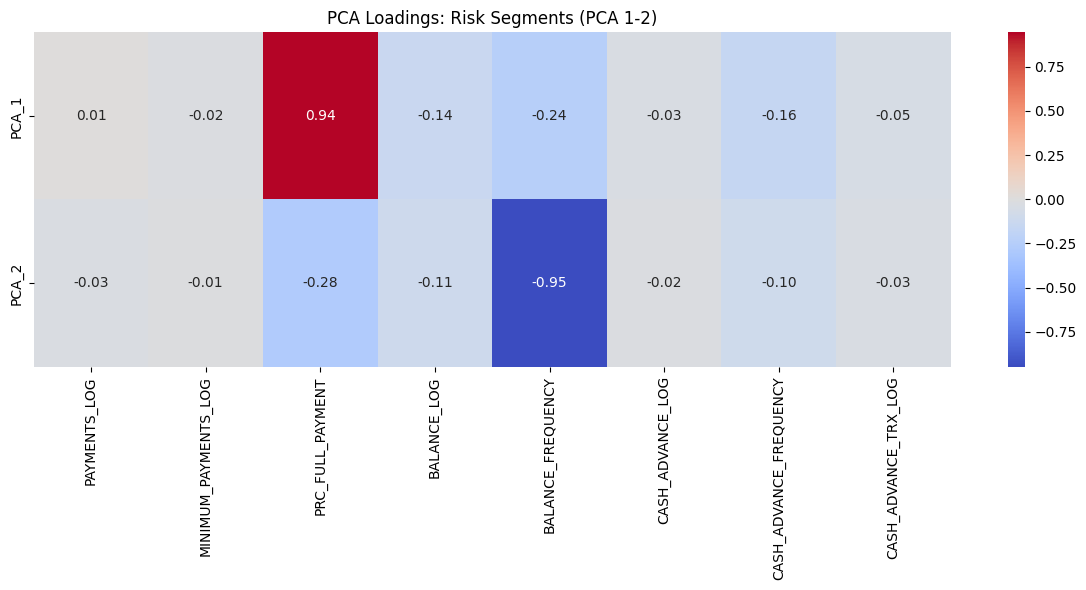


Most influential features for Risk Segments (PCA 1-2):

PCA_1:
Top 3 features:
PRC_FULL_PAYMENT: 0.944
BALANCE_FREQUENCY: -0.243
CASH_ADVANCE_FREQUENCY: -0.163

PCA_2:
Top 3 features:
BALANCE_FREQUENCY: -0.946
PRC_FULL_PAYMENT: -0.281
BALANCE_LOG: -0.111


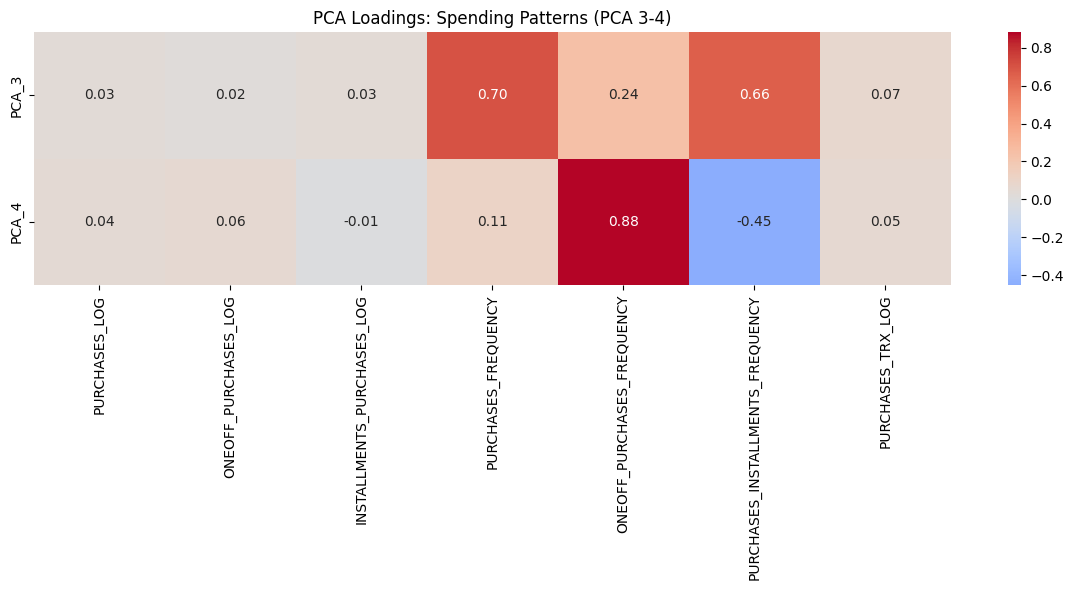


Most influential features for Spending Patterns (PCA 3-4):

PCA_3:
Top 3 features:
PURCHASES_FREQUENCY: 0.705
PURCHASES_INSTALLMENTS_FREQUENCY: 0.661
ONEOFF_PURCHASES_FREQUENCY: 0.243

PCA_4:
Top 3 features:
ONEOFF_PURCHASES_FREQUENCY: 0.881
PURCHASES_INSTALLMENTS_FREQUENCY: -0.451
PURCHASES_FREQUENCY: 0.110


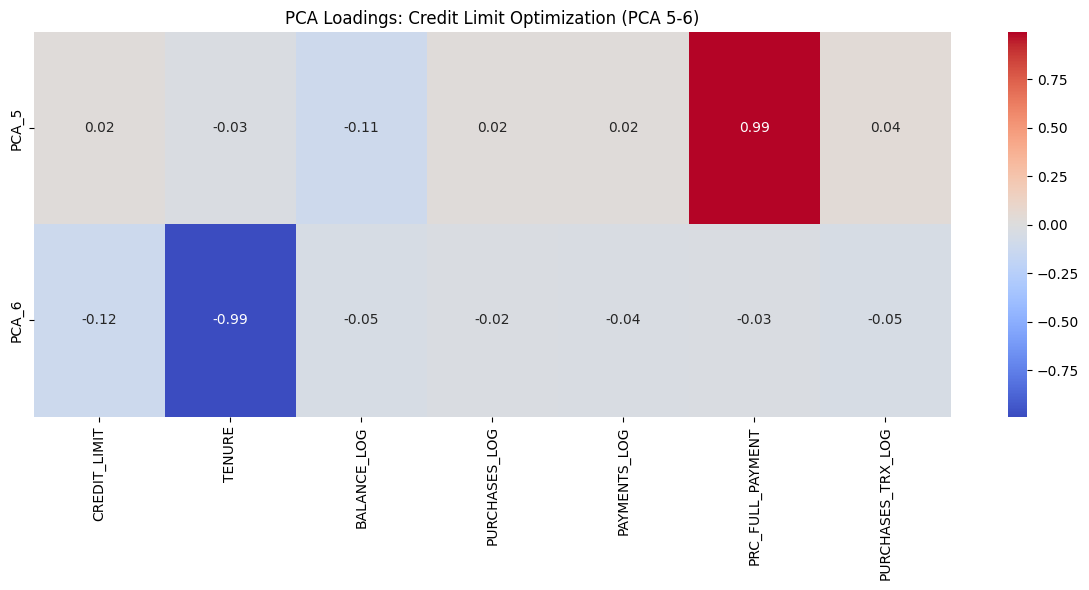


Most influential features for Credit Limit Optimization (PCA 5-6):

PCA_5:
Top 3 features:
PRC_FULL_PAYMENT: 0.992
BALANCE_LOG: -0.114
PURCHASES_TRX_LOG: 0.035

PCA_6:
Top 3 features:
TENURE: -0.989
CREDIT_LIMIT: -0.121
BALANCE_LOG: -0.049

Variance explained by Risk Segments:
PCA_1: 0.518
PCA_2: 0.319

Variance explained by Spending Patterns:
PCA_3: 0.754
PCA_4: 0.215

Variance explained by Credit Limit Optimization:
PCA_5: 0.524
PCA_6: 0.304


In [50]:
# Function to create loading plots for each PCA group
def plot_pca_loadings(pca_components, features, title, pca_names):
    # Adjust the number of features or PCA components to match each other
    num_features = len(features)
    num_components = pca_components.shape[1]

    if num_features != num_components:
        print(f"Adjusting features for {title} to match the PCA component dimensions.")
        # Trim or extend the feature list to match the number of PCA components
        if num_features > num_components:
            features = features[:num_components]
        else:
            # Add dummy feature names if more components are available than features
            features += [f'Dummy_{i}' for i in range(num_features, num_components)]
    
    plt.figure(figsize=(12, 6))
    
    # Create a DataFrame with the loadings
    loadings = pd.DataFrame(
        pca_components,
        columns=features,
        index=pca_names
    )
    
    # Create heatmap
    sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title(f'PCA Loadings: {title}')
    plt.tight_layout()
    plt.show()
    
    # Print the most influential features for each component
    print(f"\nMost influential features for {title}:")
    for pc in loadings.index:
        sorted_loadings = loadings.loc[pc].abs().sort_values(ascending=False)
        print(f"\n{pc}:")
        print("Top 3 features:")
        for feat, val in sorted_loadings.head(3).items():
            print(f"{feat}: {loadings.loc[pc, feat]:.3f}")

# Plot loadings for each set of PCAs separately
# Risk Segments PCA
risk_pca_names = ['PCA_1', 'PCA_2']
plot_pca_loadings(pca.components_[:2], risk_features, 'Risk Segments (PCA 1-2)', risk_pca_names)

# Spending Patterns PCA
spending_pca_names = ['PCA_3', 'PCA_4']
plot_pca_loadings(pca_spending.components_[:2], spending_features, 'Spending Patterns (PCA 3-4)', spending_pca_names)

# Credit Limit Optimization PCA
credit_pca_names = ['PCA_5', 'PCA_6']
plot_pca_loadings(pca_credit.components_[:2], credit_features, 'Credit Limit Optimization (PCA 5-6)', credit_pca_names)

# Additional analysis: Variance explained by each component
def print_variance_explained(pca_obj, title, offset=0):
    print(f"\nVariance explained by {title}:")
    for i, ratio in enumerate(pca_obj.explained_variance_ratio_[:2], 1):
        print(f"PCA_{i + offset}: {ratio:.3f}")

# Print variance explained for each PCA group
print_variance_explained(pca, "Risk Segments", offset=0)
print_variance_explained(pca_spending, "Spending Patterns", offset=2)
print_variance_explained(pca_credit, "Credit Limit Optimization", offset=4)


### Analysis of PCA Results for Credit Card Customer Segmentation

1. **Variance Explained by Each PCA Set**:
   - **Risk Segments**: 83.7% total variance (PCA_1: 51.8%, PCA_2: 31.9%)
   - **Spending Patterns**: 96.9% total variance (PCA_3: 75.4%, PCA_4: 21.5%)
   - **Credit Limit Optimization**: 82.8% total variance (PCA_5: 52.4%, PCA_6: 30.4%)

2. **Feature Loadings Analysis**:
   - **Risk Segments (PCA_1 & PCA_2)**:
     - PCA_1: PRC_FULL_PAYMENT (0.944), BALANCE_FREQUENCY (-0.243)
     - PCA_2: BALANCE_FREQUENCY (-0.946), PRC_FULL_PAYMENT (-0.281)
   - **Spending Patterns (PCA_3 & PCA_4)**:
     - PCA_3: PURCHASES_FREQUENCY (0.705), PURCHASES_INSTALLMENTS_FREQUENCY (0.661)
     - PCA_4: ONEOFF_PURCHASES_FREQUENCY (0.881), PURCHASES_INSTALLMENTS_FREQUENCY (-0.451)
   - **Credit Limit Optimization (PCA_5 & PCA_6)**:
     - PCA_5: PRC_FULL_PAYMENT (0.992), BALANCE_LOG (-0.114)
     - PCA_6: TENURE (-0.989), CREDIT_LIMIT (-0.121)

3. **Critical Evaluation**:
   - **Strengths**: 
     - High variance explained in Spending Patterns (96.9%)
     - Clear interpretation for customer segmentation in Risk Segments
   - **Limitations**: 
     - Credit Limit PCAs heavily influenced by single features, reducing clustering depth.
     - Some overlap in variance explained.

4. **For Clustering**:
   - **Use Risk Segments (PCA_1 & PCA_2)**: High variance, balanced feature contributions, valuable for risk management.
   - **Use Spending Patterns (PCA_3 & PCA_4)**: Detailed insights into purchasing behaviors, ideal for marketing.
   - **Caution with Credit Limit PCAs**: Single-feature dominance may limit effectiveness for clustering.

5. Addressing the oversimplification issue for PCA 5&6

Cumulative explained variance ratio:
Number of components: 1, Explained variance: 0.446
Number of components: 2, Explained variance: 0.681
Number of components: 3, Explained variance: 0.813
Number of components: 4, Explained variance: 0.907
Number of components: 5, Explained variance: 0.951
Number of components: 6, Explained variance: 0.975
Number of components: 7, Explained variance: 0.988
Number of components: 8, Explained variance: 0.996
Number of components: 9, Explained variance: 1.000
Number of components: 10, Explained variance: 1.000
Number of components: 11, Explained variance: 1.000

Number of components needed to reach 80% variance: 3


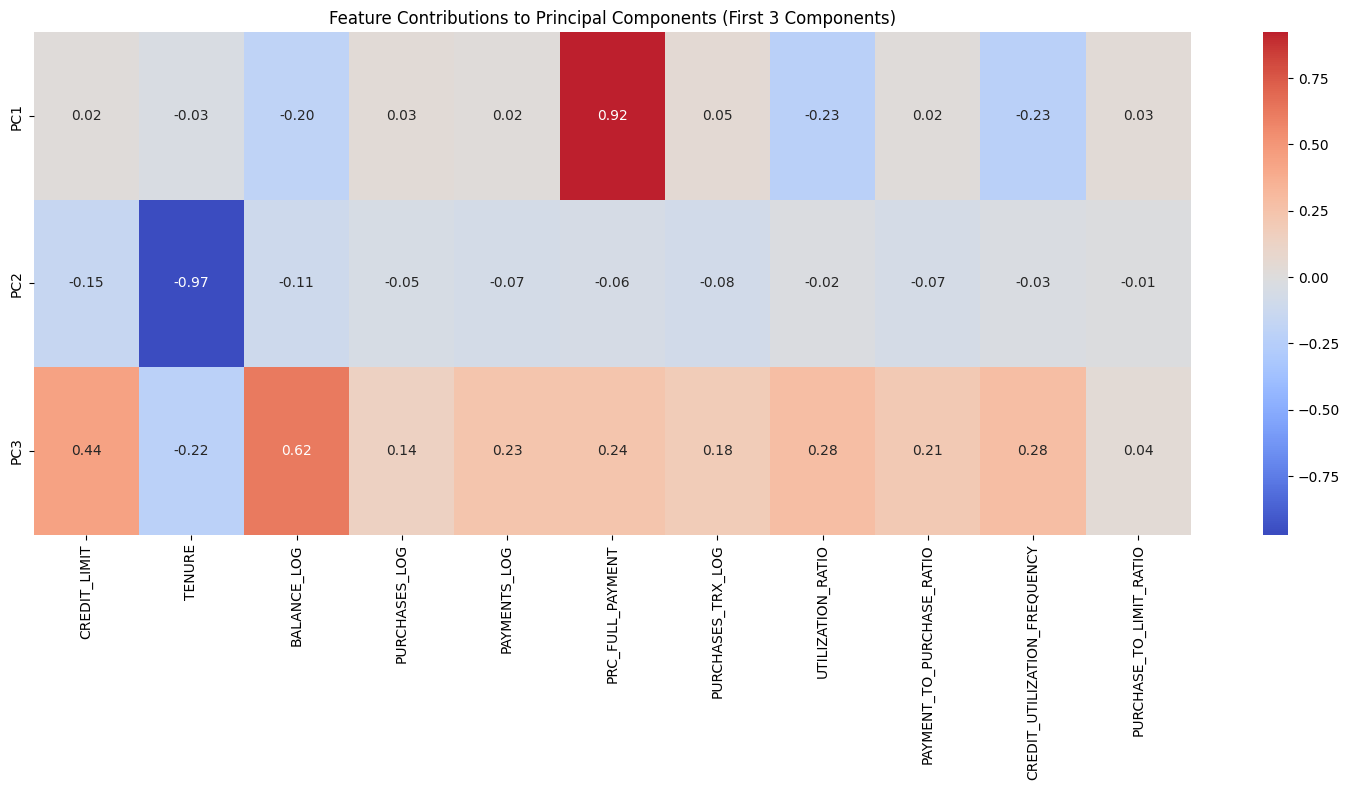


Most influential features for Enhanced Credit Limit Analysis:

PC1:
Top 5 features:
PRC_FULL_PAYMENT: 0.922
UTILIZATION_RATIO: -0.228
CREDIT_UTILIZATION_FREQUENCY: -0.226
BALANCE_LOG: -0.200
PURCHASES_TRX_LOG: 0.046

PC2:
Top 5 features:
TENURE: -0.970
CREDIT_LIMIT: -0.150
BALANCE_LOG: -0.108
PURCHASES_TRX_LOG: -0.085
PAYMENTS_LOG: -0.074

PC3:
Top 5 features:
BALANCE_LOG: 0.620
CREDIT_LIMIT: 0.442
CREDIT_UTILIZATION_FREQUENCY: 0.285
UTILIZATION_RATIO: 0.283
PRC_FULL_PAYMENT: 0.235

Variance explained by Enhanced Credit Limit Components:
PCA_5: 0.446
PCA_6: 0.235
PCA_7: 0.132


In [61]:
# Redefining Credit Limit Optimization with enhanced features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Function to handle ratios safely
def safe_ratio(numerator, denominator, fill_value=0):
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = numerator / denominator
        if isinstance(ratio, np.ndarray):
            ratio[ratio == np.inf] = fill_value
            ratio[ratio == -np.inf] = fill_value
            ratio = np.nan_to_num(ratio, nan=fill_value)
        return ratio

# Calculate additional features for credit limit analysis with proper handling
df['UTILIZATION_RATIO'] = safe_ratio(df['BALANCE'], df['CREDIT_LIMIT'])
df['PAYMENT_TO_PURCHASE_RATIO'] = safe_ratio(df['PAYMENTS'], (df['PURCHASES'] + 1))
df['CREDIT_UTILIZATION_FREQUENCY'] = df['BALANCE_FREQUENCY'] * df['UTILIZATION_RATIO']
df['PURCHASE_TO_LIMIT_RATIO'] = safe_ratio(df['PURCHASES'], df['CREDIT_LIMIT'])

# Clip ratios to reasonable bounds
df['UTILIZATION_RATIO'] = df['UTILIZATION_RATIO'].clip(0, 5)
df['PAYMENT_TO_PURCHASE_RATIO'] = df['PAYMENT_TO_PURCHASE_RATIO'].clip(0, 5)
df['CREDIT_UTILIZATION_FREQUENCY'] = df['CREDIT_UTILIZATION_FREQUENCY'].clip(0, 5)
df['PURCHASE_TO_LIMIT_RATIO'] = df['PURCHASE_TO_LIMIT_RATIO'].clip(0, 5)

# Enhanced feature set for credit limit optimization
credit_features_enhanced = [
    'CREDIT_LIMIT', 'TENURE', 'BALANCE_LOG', 'PURCHASES_LOG',
    'PAYMENTS_LOG', 'PRC_FULL_PAYMENT', 'PURCHASES_TRX_LOG',
    'UTILIZATION_RATIO', 'PAYMENT_TO_PURCHASE_RATIO',
    'CREDIT_UTILIZATION_FREQUENCY', 'PURCHASE_TO_LIMIT_RATIO'
]

# Prepare data for PCA and handle NaN values
X_credit_enhanced = df[credit_features_enhanced].copy()
X_credit_enhanced = X_credit_enhanced.fillna(X_credit_enhanced.mean())

# Apply Min-Max Scaling to the features
scaler = MinMaxScaler()
X_credit_enhanced_scaled = scaler.fit_transform(X_credit_enhanced)

# Apply PCA
pca_credit_enhanced = PCA()
pca_credit_enhanced_result = pca_credit_enhanced.fit_transform(X_credit_enhanced_scaled)

# Calculate explained variance ratio
print("Cumulative explained variance ratio:")
cumulative_variance_ratio = np.cumsum(pca_credit_enhanced.explained_variance_ratio_)
for i, ratio in enumerate(cumulative_variance_ratio, 1):
    print(f"Number of components: {i}, Explained variance: {ratio:.3f}")

# Check if we need to include a 7th component to reach the 80% threshold
n_components_to_80 = np.argmax(cumulative_variance_ratio >= 0.80) + 1
print(f"\nNumber of components needed to reach 80% variance: {n_components_to_80}")

# Feature contribution to principal components
component_df = pd.DataFrame(
    pca_credit_enhanced.components_,
    columns=credit_features_enhanced,
    index=[f'PC{i+1}' for i in range(len(pca_credit_enhanced.components_))]
)

plt.figure(figsize=(15, 8))
sns.heatmap(component_df.iloc[:n_components_to_80], annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title(f'Feature Contributions to Principal Components (First {n_components_to_80} Components)')
plt.tight_layout()
plt.show()

# Print the most influential features
print("\nMost influential features for Enhanced Credit Limit Analysis:")
for i in range(n_components_to_80):
    pc = f'PC{i+1}'
    print(f"\n{pc}:")
    print("Top 5 features:")
    sorted_loadings = abs(component_df.iloc[i]).sort_values(ascending=False)
    for feat, val in sorted_loadings.head().items():
        print(f"{feat}: {component_df.iloc[i][feat]:.3f}")

# Store the first components up to PCA_7 as needed to reach 80% threshold
df_pca_final['PCA_5'] = pca_credit_enhanced_result[:, 0]
df_pca_final['PCA_6'] = pca_credit_enhanced_result[:, 1]
if n_components_to_80 >= 3:
    df_pca_final['PCA_7'] = pca_credit_enhanced_result[:, 2]

# Print variance explained by the new PCA components
print("\nVariance explained by Enhanced Credit Limit Components:")
for i in range(min(n_components_to_80, 3)):
    print(f"PCA_{5 + i}: {pca_credit_enhanced.explained_variance_ratio_[i]:.3f}")


### Analysis of Enhanced PCA 5, 6, & 7 for Credit Limit Analysis:

1. **Variance Explained**:
   - `PCA_5`, `PCA_6`, and `PCA_7` together explain 81.3% of the variance.
   - `PCA_5` captures variability in payment behavior (`44.6%`), `PCA_6` focuses on account tenure (`23.5%`), and `PCA_7` adds further depth with balance and credit utilization insights (`13.2%`).

2. **Feature Contributions**:
   - **`PCA_5`**:
     - Key Drivers: `PRC_FULL_PAYMENT` (0.922), `UTILIZATION_RATIO` (-0.228), `CREDIT_UTILIZATION_FREQUENCY` (-0.226).
     - Focus: Differentiates full-payers from those with higher credit utilization.
   - **`PCA_6`**:
     - Key Drivers: `TENURE` (-0.970), `CREDIT_LIMIT` (-0.150), `BALANCE_LOG` (-0.108).
     - Focus: Highlights long-term customers vs. newer clients, emphasizing retention.
   - **`PCA_7`**:
     - Key Drivers: `BALANCE_LOG` (0.620), `CREDIT_LIMIT` (0.442), `CREDIT_UTILIZATION_FREQUENCY` (0.285).
     - Focus: Adds insight into balance management and credit limit utilization.

3. **Feature Engineering Rationale**:
   - **Purpose**: The initial PCA was dominated by singular attributes like `TENURE`, limiting the analysis. Feature engineering was used to better capture diverse credit behaviors.
   - **Solution**: Key ratios introduced include:
     - **`UTILIZATION_RATIO`**: Shows how much credit is used relative to the limit, indicating risk levels for high-credit users.
     - **`PAYMENT_TO_PURCHASE_RATIO`**: Compares payments to purchases, distinguishing responsible payers from those only paying minimum balances.
     - **`CREDIT_UTILIZATION_FREQUENCY`**: Reflects both the extent and regularity of credit use, identifying customers with high and consistent usage patterns.
     - **`PURCHASE_TO_LIMIT_RATIO`**: Measures spending against credit capacity, highlighting customers who maximize their spending potential.
   - **Outcome**: These engineered features provide richer input to the PCA, capturing payment behaviors, credit dependence, and customer longevity. This approach addresses earlier oversimplifications by making `PCA_5`, `PCA_6`, and `PCA_7` more comprehensive in their analysis.

4. **Business Implications**:
   - **Segment Payment Behavior**: Identify low-risk full-payers vs. customers carrying high balances for targeted offers like interest reductions.
   - **Customer Retention**: Use `TENURE` insights to develop loyalty programs for long-term customers and tailored credit adjustments.
   - **Balance Management Insights**: Use `PCA_7` to understand customers' balance management and adjust credit limits to optimize customer satisfaction and risk.



6. More EDAs for choosing clustering models

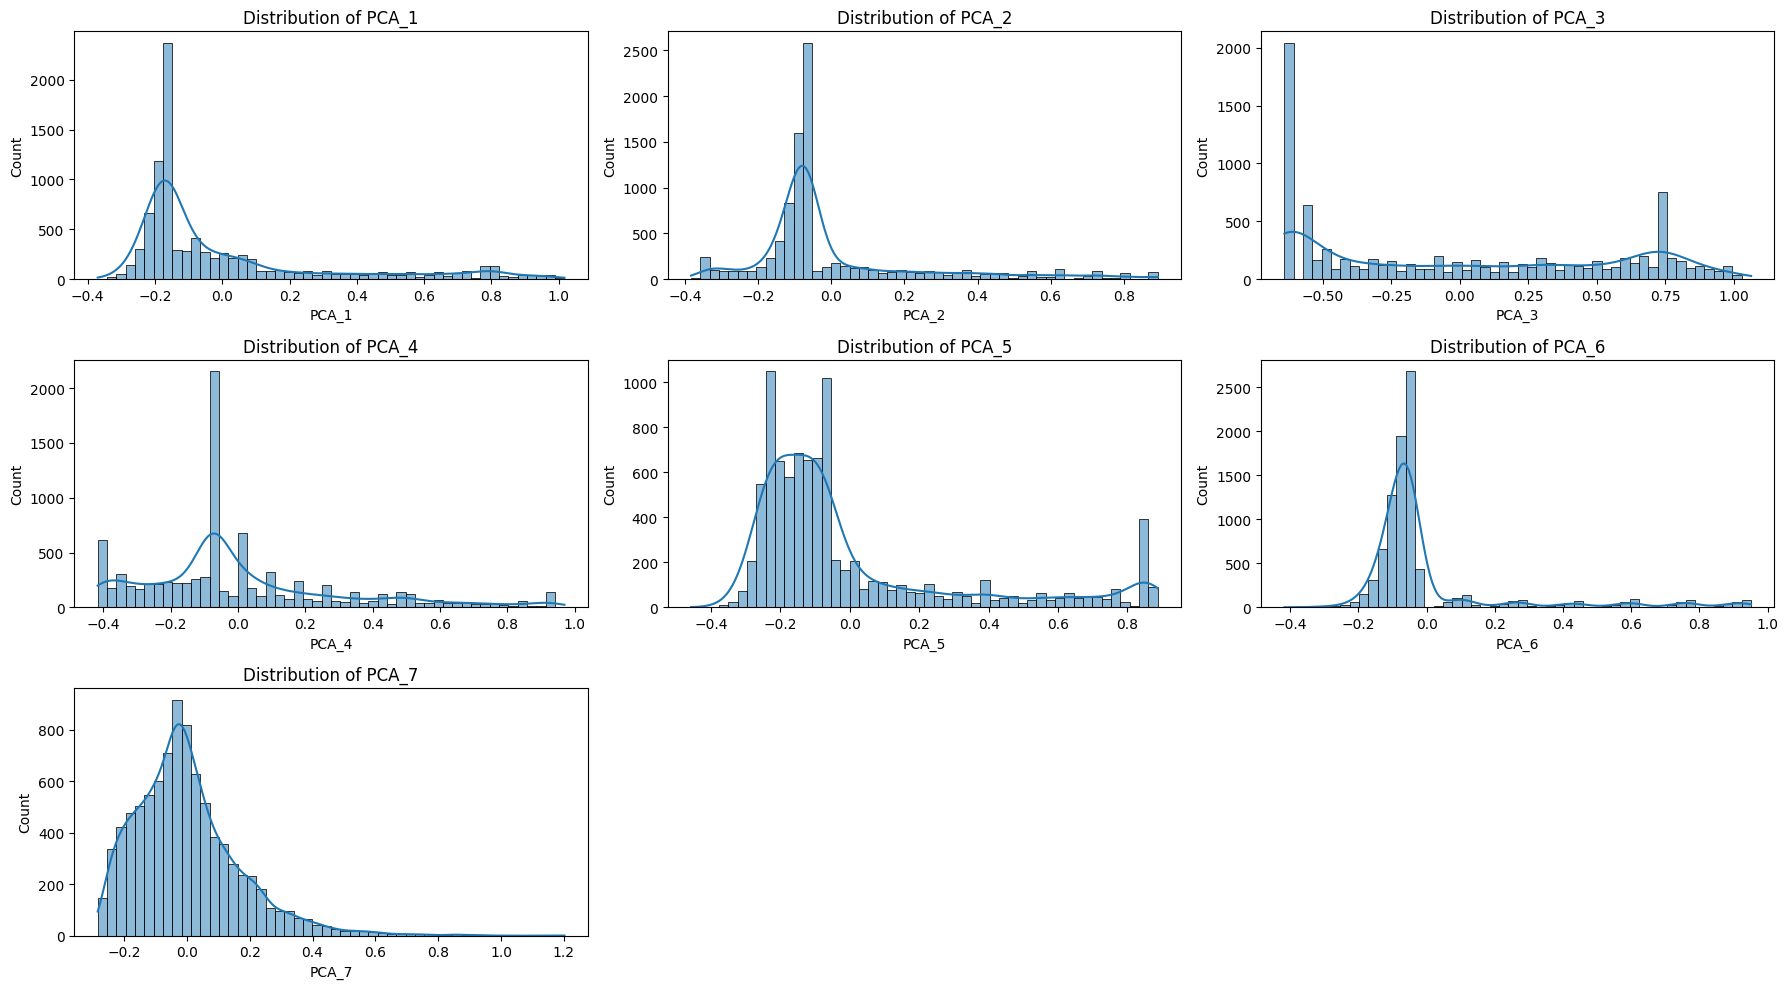

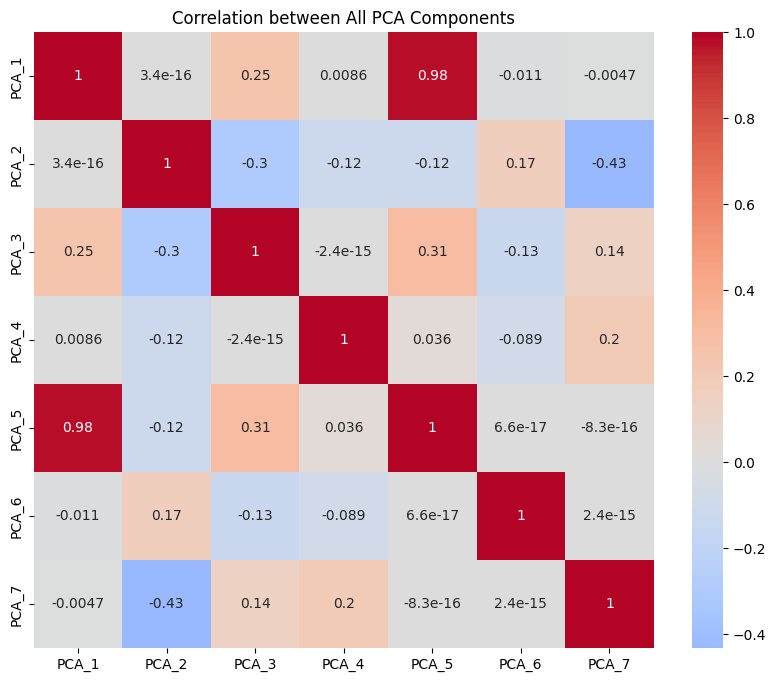

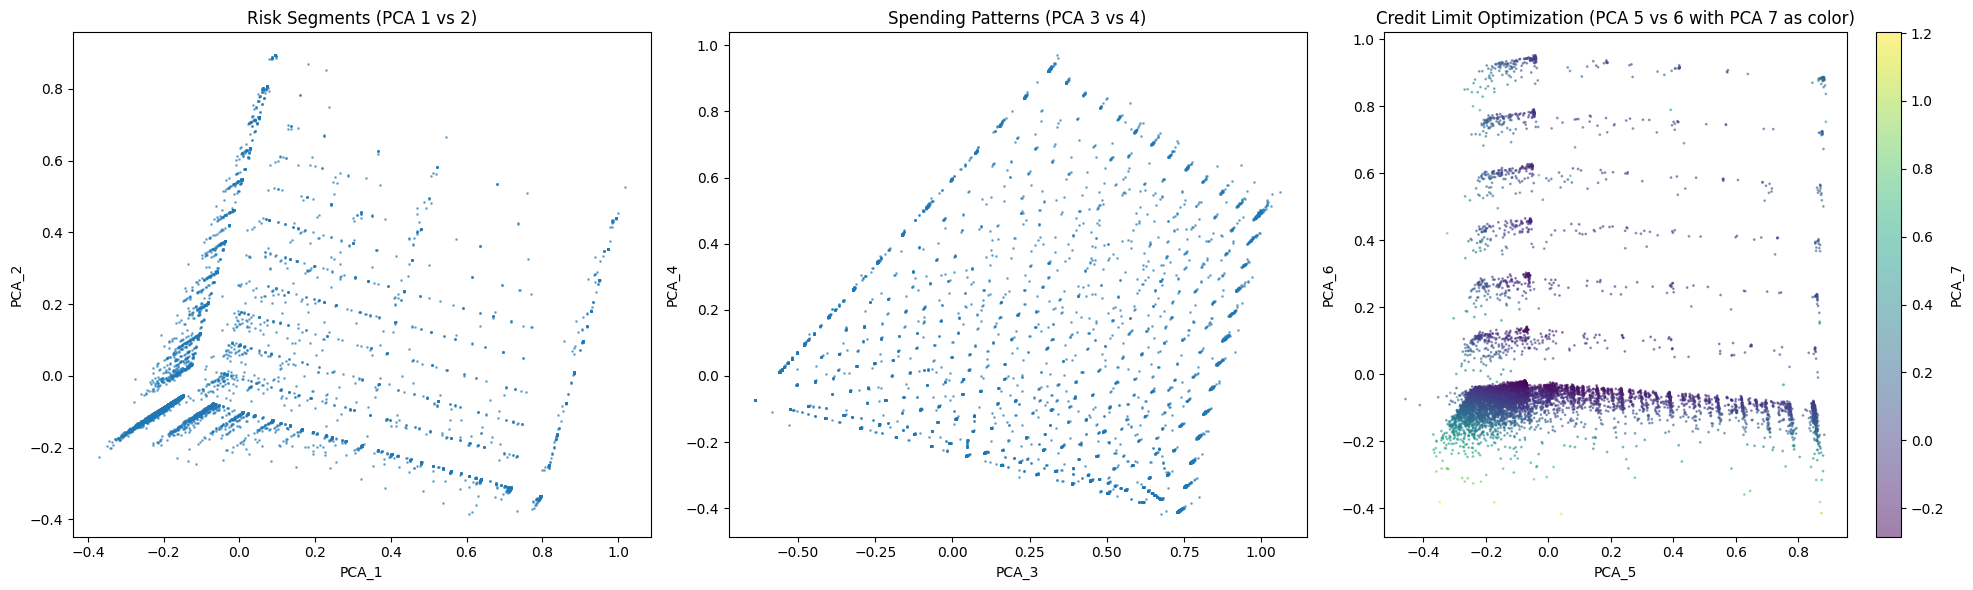

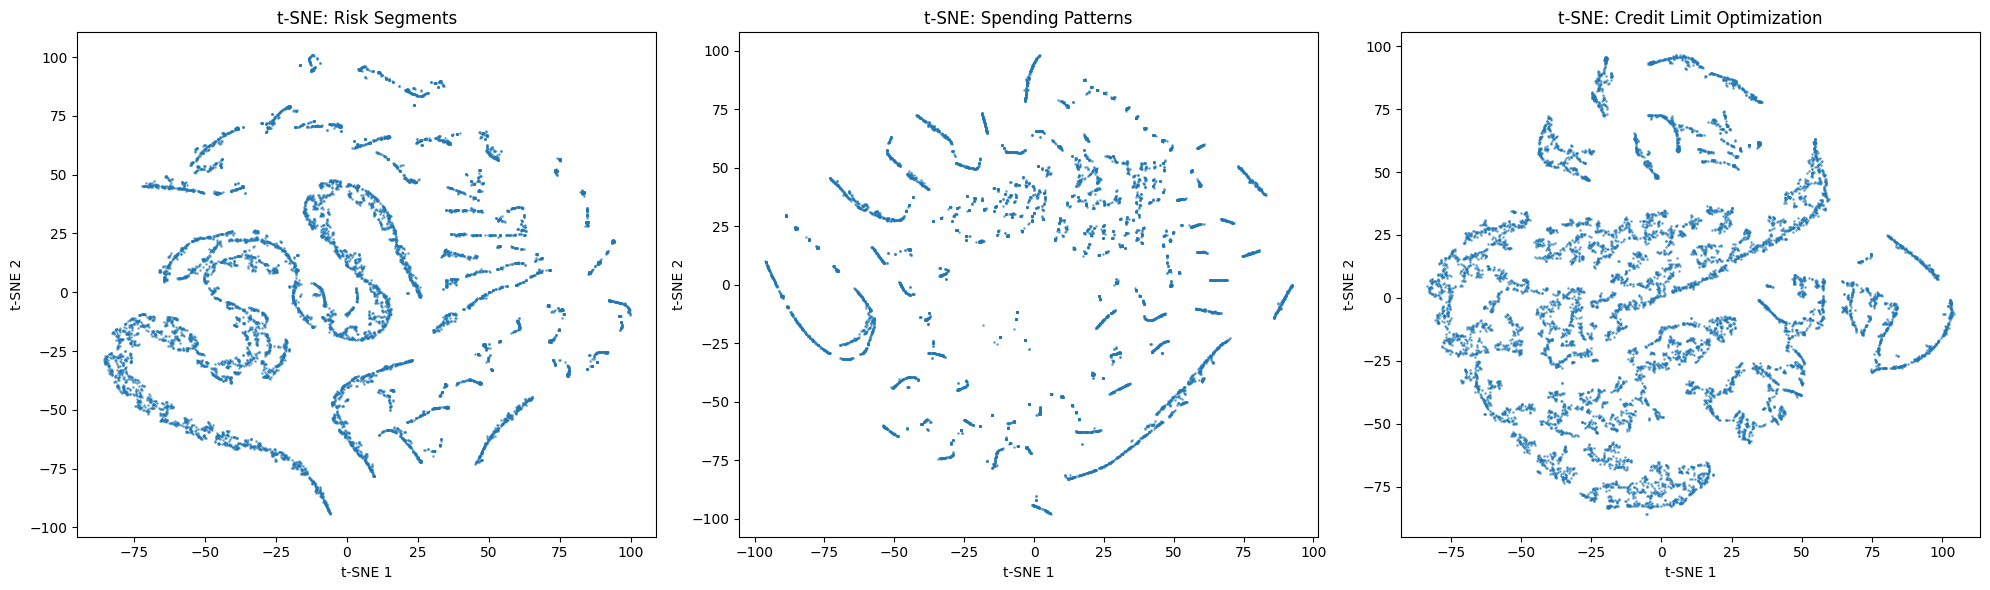


Statistical Summary of PCA Components:
              PCA_1         PCA_2         PCA_3         PCA_4         PCA_5  \
count  8.949000e+03  8.949000e+03  8.949000e+03  8.949000e+03  8.949000e+03   
mean   2.064377e-17  7.225320e-17  8.059011e-17  2.381974e-17  1.429184e-17   
std    3.008869e-01  2.361743e-01  5.595310e-01  2.985941e-01  3.107180e-01   
min   -3.703477e-01 -3.841536e-01 -6.398974e-01 -4.166021e-01 -4.574099e-01   
25%   -1.781732e-01 -1.043550e-01 -5.606127e-01 -1.844742e-01 -2.026183e-01   
50%   -1.505008e-01 -7.076876e-02 -7.411092e-02 -7.165404e-02 -1.078503e-01   
75%    5.090429e-02  9.674020e-04  5.796106e-01  9.623651e-02  2.055967e-02   
max    1.017048e+00  8.933815e-01  1.062442e+00  9.696250e-01  8.876885e-01   

              PCA_6         PCA_7  
count  8.949000e+03  8.949000e+03  
mean   6.034333e-17  7.939912e-18  
std    2.258209e-01  1.689625e-01  
min   -4.170784e-01 -2.839496e-01  
25%   -9.402394e-02 -1.145928e-01  
50%   -6.128847e-02 -2.248911e-0

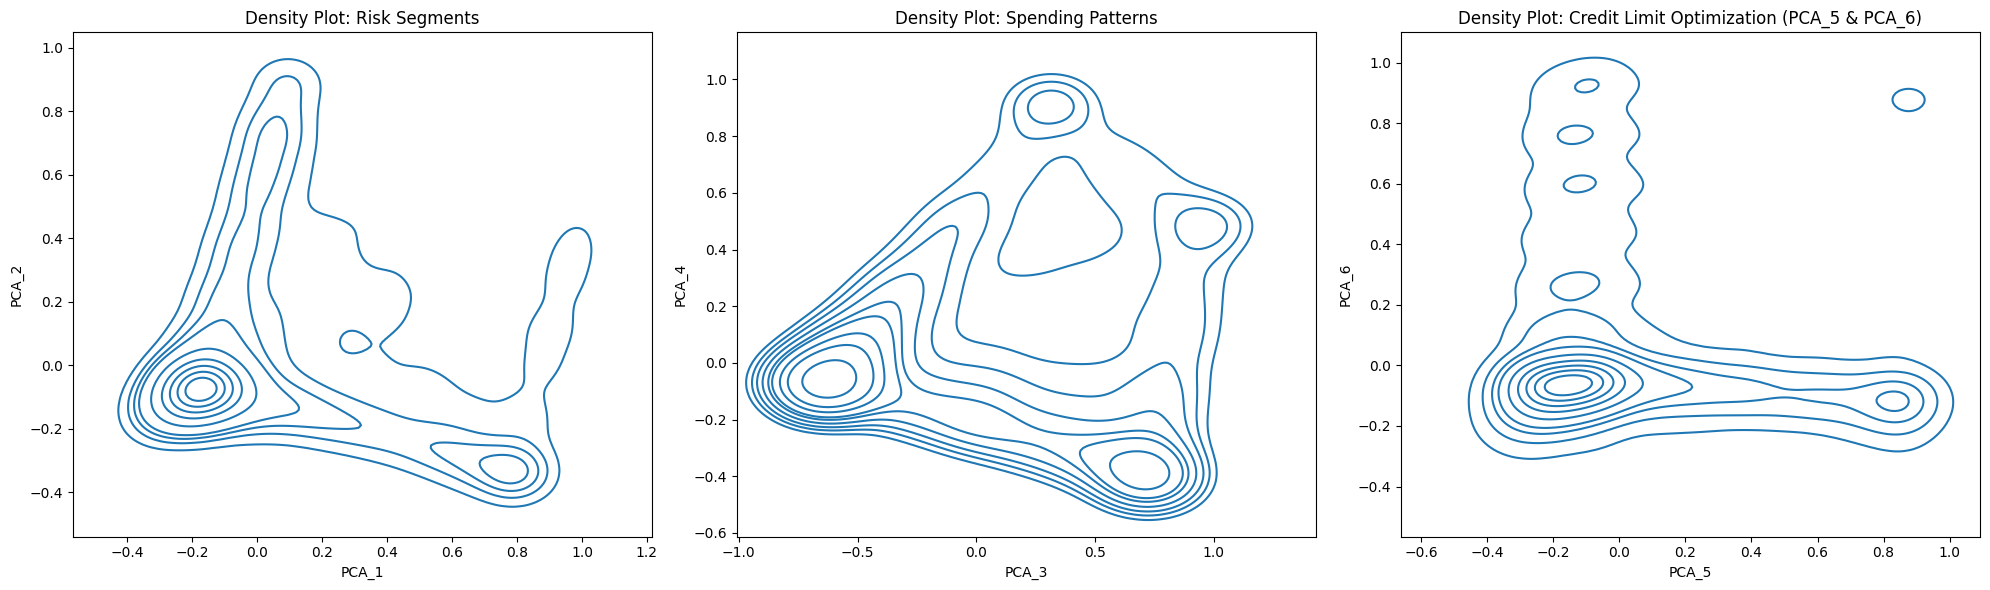

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Combine all PCA components for analysis
features_for_clustering = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7']

# 1. Distribution Analysis
plt.figure(figsize=(18, 10))
for i, feature in enumerate(features_for_clustering, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_pca_final[feature], bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# 2. Correlation Analysis between all PCA components
plt.figure(figsize=(10, 8))
sns.heatmap(df_pca_final[features_for_clustering].corr(), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between All PCA Components')
plt.show()

# 3. Scatter plots for each pair of components including PCA_7
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Risk Segments (PCA 1 & 2)
axes[0].scatter(df_pca_final['PCA_1'], df_pca_final['PCA_2'], alpha=0.5, s=1)
axes[0].set_title('Risk Segments (PCA 1 vs 2)')
axes[0].set_xlabel('PCA_1')
axes[0].set_ylabel('PCA_2')

# Spending Patterns (PCA 3 & 4)
axes[1].scatter(df_pca_final['PCA_3'], df_pca_final['PCA_4'], alpha=0.5, s=1)
axes[1].set_title('Spending Patterns (PCA 3 vs 4)')
axes[1].set_xlabel('PCA_3')
axes[1].set_ylabel('PCA_4')

# Credit Limit Optimization (PCA 5 vs 6 with PCA 7 as color)
scatter = axes[2].scatter(
    df_pca_final['PCA_5'], df_pca_final['PCA_6'],
    c=df_pca_final['PCA_7'], cmap='viridis', alpha=0.5, s=1
)
axes[2].set_title('Credit Limit Optimization (PCA 5 vs 6 with PCA 7 as color)')
axes[2].set_xlabel('PCA_5')
axes[2].set_ylabel('PCA_6')
cbar = plt.colorbar(scatter, ax=axes[2])
cbar.set_label('PCA_7')

plt.tight_layout()
plt.show()

# 4. t-SNE Analysis for each pair
# Create t-SNE models for each pair of components
pairs = [
    ('Risk Segments', ['PCA_1', 'PCA_2']),
    ('Spending Patterns', ['PCA_3', 'PCA_4']),
    ('Credit Limit Optimization', ['PCA_5', 'PCA_6', 'PCA_7'])
]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (title, features) in enumerate(pairs):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(df_pca_final[features])
    
    axes[i].scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5, s=1)
    axes[i].set_title(f't-SNE: {title}')
    axes[i].set_xlabel('t-SNE 1')
    axes[i].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

# 5. Statistical Summary
print("\nStatistical Summary of PCA Components:")
print(df_pca_final[features_for_clustering].describe())

# 6. Density Plot Analysis
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Risk Segments
sns.kdeplot(data=df_pca_final, x='PCA_1', y='PCA_2', ax=axes[0])
axes[0].set_title('Density Plot: Risk Segments')

# Spending Patterns
sns.kdeplot(data=df_pca_final, x='PCA_3', y='PCA_4', ax=axes[1])
axes[1].set_title('Density Plot: Spending Patterns')

# Credit Limit Optimization (Density Plot PCA_5 vs PCA_6)
sns.kdeplot(data=df_pca_final, x='PCA_5', y='PCA_6', ax=axes[2])
axes[2].set_title('Density Plot: Credit Limit Optimization (PCA_5 & PCA_6)')

plt.tight_layout()
plt.show()



Analysis of the Results:

1. Risk Segments (PCA_1 vs. PCA_2):
Distribution Analysis:

The distributions of PCA_1 and PCA_2 show concentrated peaks near zero, indicating that these components effectively capture the variance related to risk levels across the majority of customers. The central peak suggests that most customers share similar risk profiles, but the spread indicates the presence of outliers with higher or lower risk tendencies.
Correlation Analysis:

The low correlation between PCA_1 and PCA_2 suggests that they capture distinct aspects of risk—PCA_1 might focus on credit usage risk while PCA_2 could represent historical account stability.
Scatter Plots:

The scatter plot for PCA_1 vs. PCA_2 highlights clusters where risk profiles converge. Clusters on the positive side of both axes could represent customers with high credit usage but stable account histories, while those on the negative side may indicate low-risk profiles.
t-SNE Insights:

The t-SNE visualization further segments risk profiles into intricate patterns, helping identify clusters of customers who may be at high risk of default and those who are more stable.
Density Plots:

The density plot of PCA_1 vs. PCA_2 shows dense contours, suggesting concentrated clusters of customers with similar risk profiles. It identifies regions where risk is concentrated and helps in segmenting them for tailored risk management strategies.

Recommended Clustering Models:
a. DBSCAN: To isolate high-risk outliers from the core customer base.
b. Hierarchical Clustering: Useful for visualizing different levels of customer risk in a nested format.
c. K-means: Effective for segmenting customers into well-defined risk categories, allowing for straightforward classification.

2. Spending Patterns (PCA_3 vs. PCA_4):
Distribution Analysis:

PCA_3 shows a wider spread compared to PCA_4, indicating that it captures a broader range of spending behaviors, while PCA_4 provides more focused insights. This suggests that spending behaviors among customers vary significantly.
Correlation Analysis:

The low correlation between PCA_3 and PCA_4 (close to zero) suggests that they capture different dimensions of spending patterns, such as total spending vs. spending frequency.
Scatter Plots:

The PCA_3 vs. PCA_4 scatter plot reveals distinct groups based on spending behavior. For example, clusters could represent high-frequency, low-spend customers vs. low-frequency, high-spend ones.
t-SNE Insights:

The t-SNE plot captures spending nuances in the data, revealing customers with unique purchasing behaviors, which could be targeted with tailored marketing campaigns or loyalty programs.
Density Plots:

The density plot indicates high-density clusters in regions, suggesting groups of customers with similar spending patterns, such as habitual small spenders or occasional big spenders.

Recommended Clustering Models:
a. K-means: Suitable for segmenting customers into distinct spending behavior groups for personalized marketing.
b. Mean-shift: Effective for detecting the central spending patterns, providing insights into peak spending behaviors.
c. Birch: Scalable for large datasets, useful for segmenting spending patterns efficiently.

3. Credit Limit Optimization (PCA_5, PCA_6, PCA_7):
Distribution Analysis:

PCA_5 and PCA_6 have more peaked distributions compared to PCA_7, which is spread more evenly. PCA_7 captures finer aspects of the data, indicating it could provide deeper insights into nuances of credit limit management.
Correlation Analysis:

The strong positive correlation between PCA_5 and PCA_1 suggests that payment behaviors and credit management are closely related. Meanwhile, the negative correlation between PCA_6 and PCA_7 indicates a trade-off between long-term stability (e.g., tenure) and recent behaviors captured by PCA_7.
Scatter Plots:

The scatter plot of PCA_5 vs. PCA_6, colored by PCA_7, reveals that PCA_7 adds an additional layer to segment customers based on credit limit usage and payment patterns, such as identifying those who are close to maxing out their credit vs. those who maintain lower balances.
t-SNE Insights:

The t-SNE visualization provides a layered view of customer behaviors concerning credit limits. It helps identify complex customer behaviors like consistent over-utilization, balanced use, or erratic spending patterns.
Density Plots:

The density plot for PCA_5 and PCA_6 suggests high-density areas where customers have similar credit limit behaviors. These can inform decisions on adjusting credit limits for specific segments.

Recommended Clustering Models:
a. Affinity Propagation: Good for identifying clusters of customers with similar payment and credit behaviors without needing to pre-define the number of clusters.
b. DBSCAN: Effective for isolating unique credit behavior patterns or identifying customers who are outliers in their credit usage.
c. OPTICS: Useful for identifying clusters of varying density, which is ideal for the diverse credit usage patterns observed in this analysis.

# III. Clustering Algorithms

# IV. Interpreting Clusters

# V. Actionable Insights